**Данный "ноутбук"** представляет решение задачи, в интересах подразделения [конфиденциально]. Реализована модель на основе сверточной нейронной сети (CNN), по анализу трафика на L3VPN-ах межрегионального сегмента [конфиденциально]. 
Данные были выгружены из системы мониторинга Orion SolarWind.

In [ ]:
import os
import math

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [ ]:
data_dir = "data"
data_file = "data.csv"
data_path = "./data.csv"

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
df = pd.read_csv(data_path, index_col=0)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45822 entries, 2023-10-01 00:00:00+00:00 to 2023-11-01 19:49:00+00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TotalBytes  45822 non-null  float64
dtypes: float64(1)
memory usage: 716.0 KB


In [ ]:
df.describe()

,TotalBytes
count,45822.00000
mean,117733989.05783
std,108767528.05479
min,14590410.00000
25%,40445537.50000
50%,59085960.00000
75%,192406160.00000
max,1041472076.00000


Данные как есть!

<Axes: xlabel='TimeStamp'>

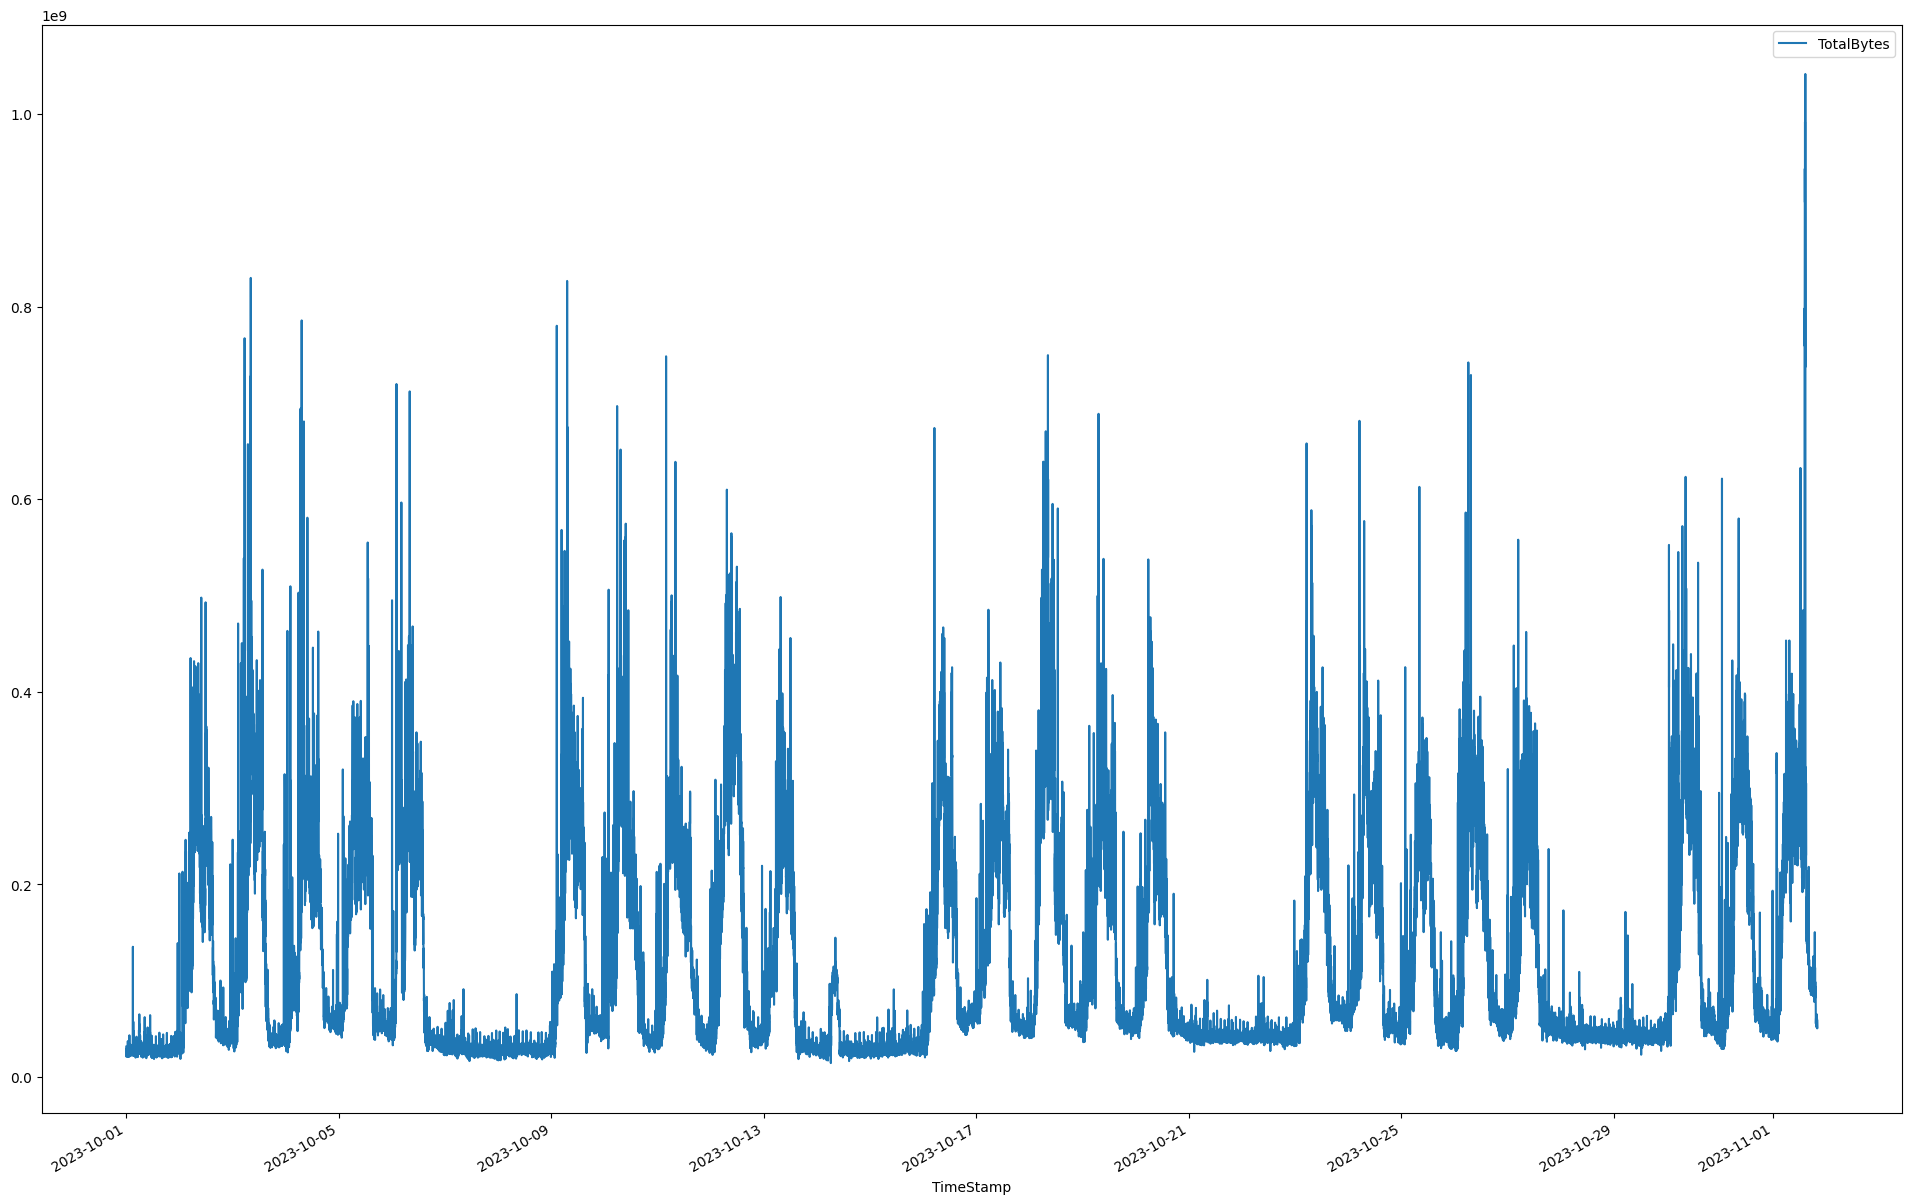

In [ ]:
df.plot(figsize=(24,16))

Данные сглаженные с помощью скользящего среднего.

<Axes: title={'center': 'Window size = 60 (smooth by day)'}, xlabel='TimeStamp,TimeStamp,TimeStamp,TimeStamp'>

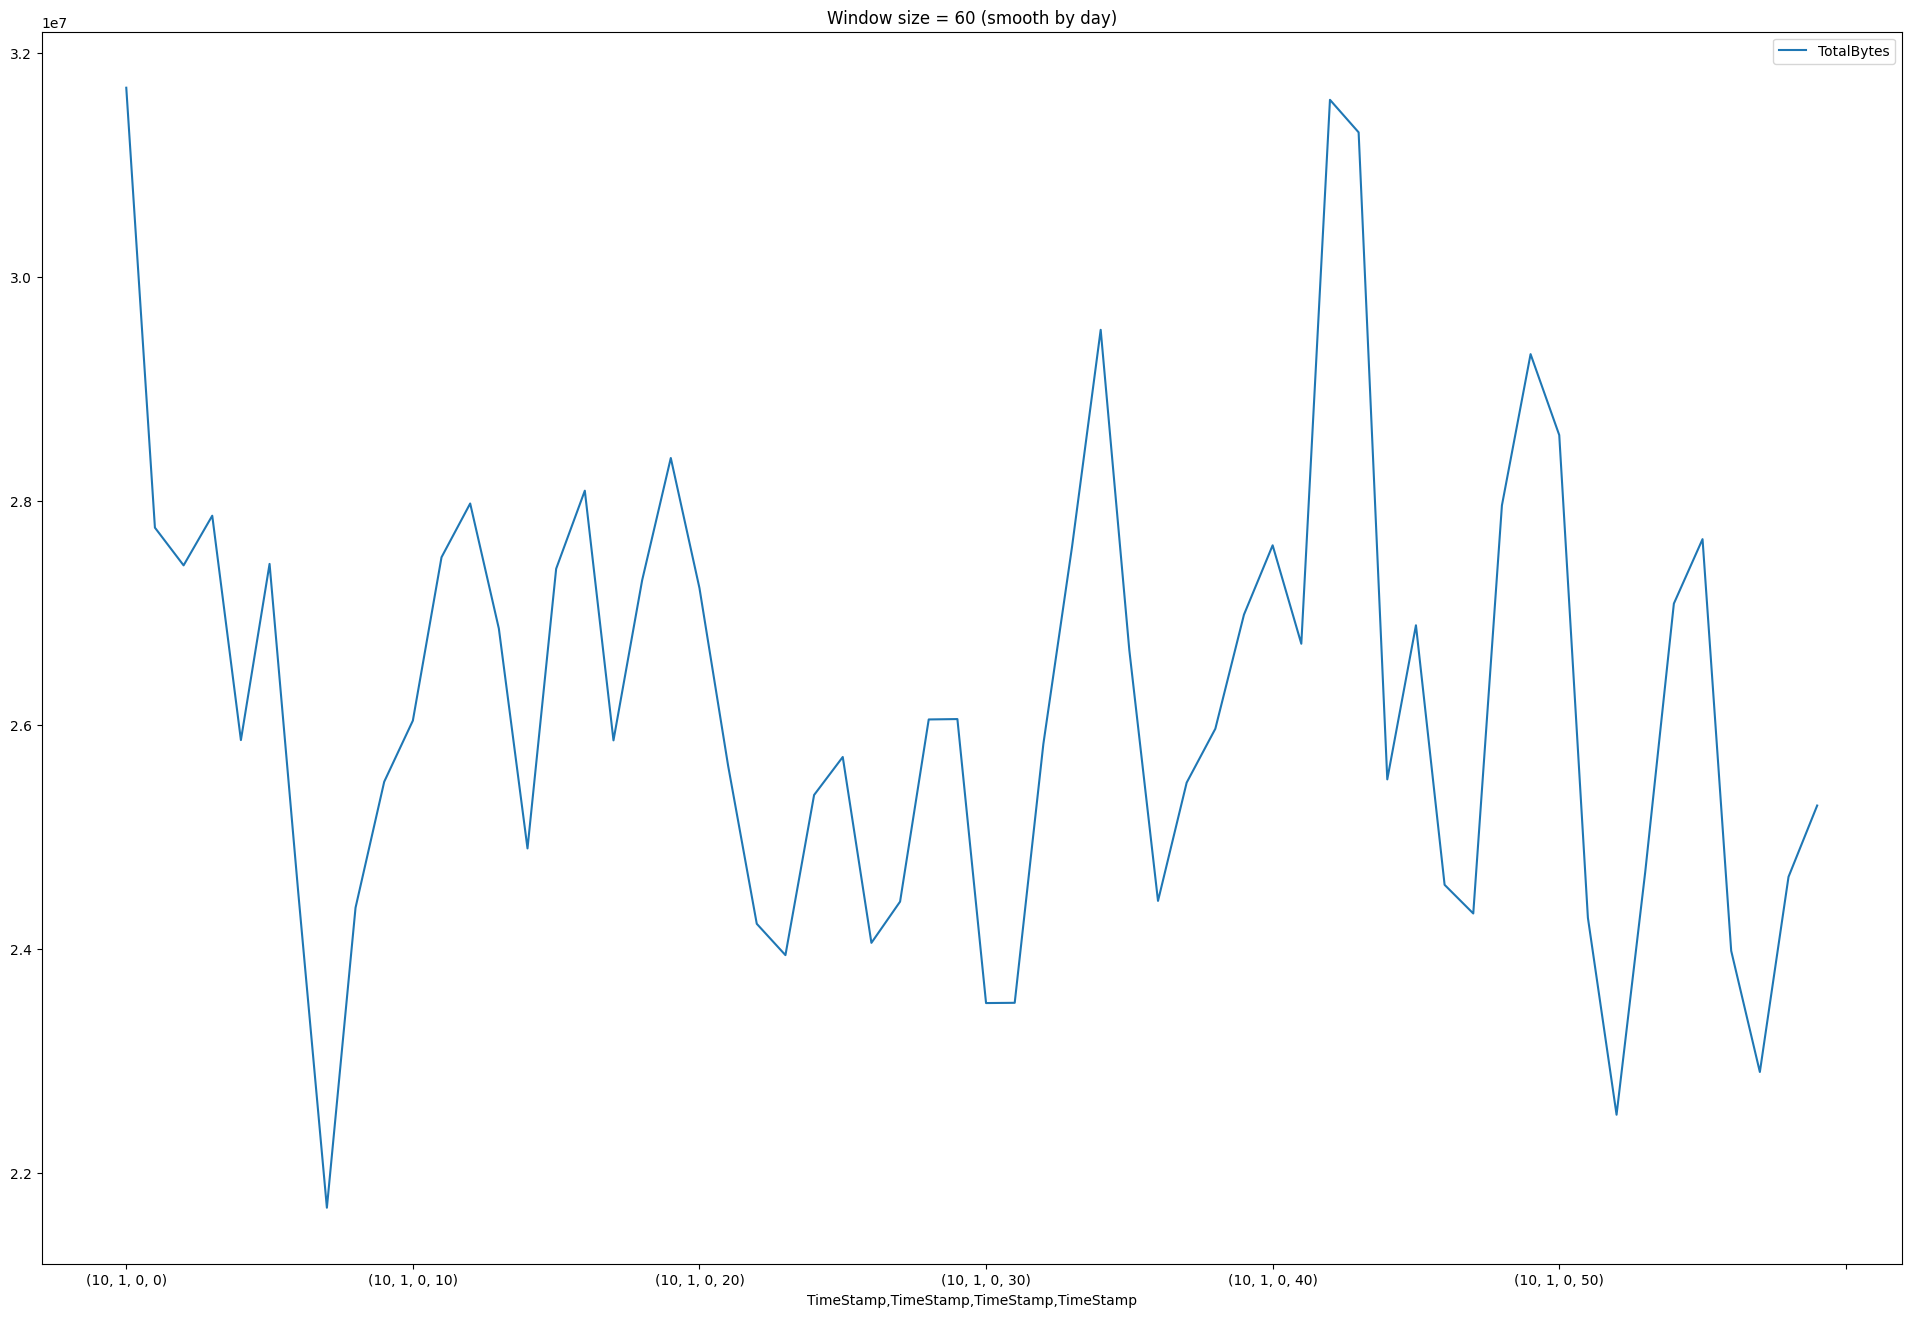

In [ ]:
df[:60].groupby([
    df[:60].index.month,
    df[:60].index.day,
    df[:60].index.hour,
    df[:60].index.minute
]).agg({
    "TotalBytes": "max"
}).rolling(60, closed="both").mean().plot(figsize=(24,16), title="Window size = 1440 (smooth by day)")

In [ ]:
training_data_len = math.ceil(len(df) * .8)
train_data = df[:training_data_len]
test_data = df[training_data_len:]

In [ ]:
len(train_data), len(test_data)

(36658, 9164)

In [ ]:
dataset_train = train_data.TotalBytes.values
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(36658, 1)

In [ ]:
dataset_test = test_data.TotalBytes.values
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(9164, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)

print(*scaled_train[:5])
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[0.0209799] [0.0113379] [0.02015329] [0.01242629] [0.01523613]
[0.19928675] [0.24904116] [0.21145214] [0.21691706] [0.2457203]


In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
x_train, y_train = split_sequence(scaled_train, 12)
x_test, y_test = split_sequence(scaled_test, 12)

In [ ]:
class ModelLSTM(nn.Module):
    def __init__(self, out_dim, input_size, hidden_size, num_layers):
        super().__init__()
        self.out_dim = out_dim 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc_2 = nn.Linear(128, out_dim)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out)
        out = self.fc_2(out)
        return out

In [ ]:
EPOCHS = 100
BATCH_SIZE = 16

OUT = 1
INP = 1
HID = 64
LAY = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelLSTM(OUT, INP, HID, LAY).to(device)
criterion = nn.MSELoss(reduction="mean").to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, mode="min")

train_ds = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_ds = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x, y) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader, start=1):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)

            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
train_loss, val_loss = [], []
for epoch in range(1, EPOCHS + 1):
    t_loss = train(model, train_dl, optimizer, criterion)
    v_loss = evaluate(model, test_dl, criterion)
    print("-------------------------------------")
    print(f"[epoch: {epoch}/{EPOCHS}], train loss: {t_loss}, valid loss: {v_loss}")
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    scheduler.step(v_loss)

-------------------------------------
[epoch: 1/100], train loss: 0.017724726106426773, valid loss: 0.012382281010289077
-------------------------------------
[epoch: 2/100], train loss: 0.017619908600923655, valid loss: 0.012517018784584487
-------------------------------------
[epoch: 3/100], train loss: 0.017533625774239996, valid loss: 0.012305587118586576
-------------------------------------
[epoch: 4/100], train loss: 0.017460253285402648, valid loss: 0.012525441841717111
-------------------------------------
[epoch: 5/100], train loss: 0.017366972842771236, valid loss: 0.012052774744782389
-------------------------------------
[epoch: 6/100], train loss: 0.017279462149591945, valid loss: 0.012207674594547998
-------------------------------------
[epoch: 7/100], train loss: 0.017196120014385734, valid loss: 0.012047157537419442
-------------------------------------
[epoch: 8/100], train loss: 0.01708434159785756, valid loss: 0.012034059183034433
---------------------------------

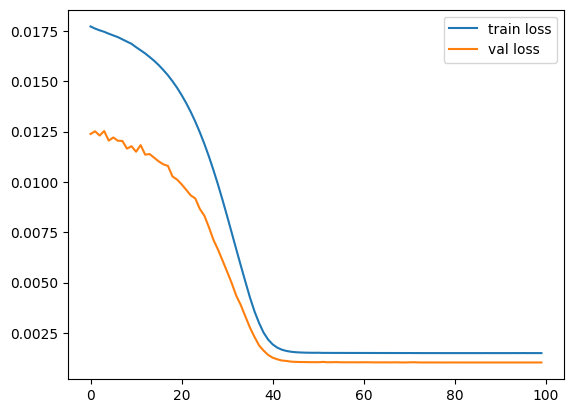

In [ ]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [ ]:
check = test_data[:72]

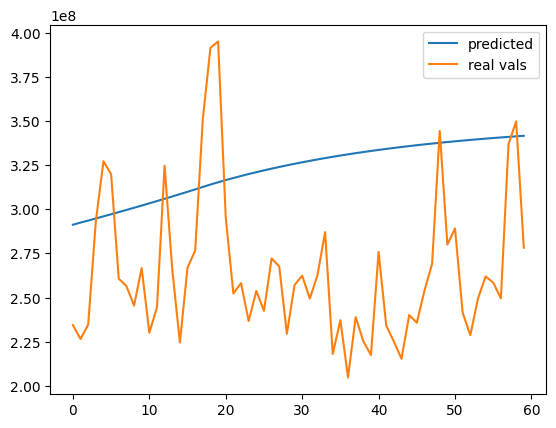

In [ ]:
model.eval()
reals = check[12:].values.tolist()
preds = []
seq = check[:12].values.tolist()
seq = scaler.transform(seq).tolist()
with torch.no_grad():
    for i in range(60):
        tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        res = model(tensor).cpu()
        res = res.item()
        preds.append(scaler.inverse_transform([[res]]).item())
        seq = seq[1:]
        seq.append([res])
plt.plot(preds, label="predicted")
plt.plot(reals, label="real vals")
plt.legend()
plt.show()

В финальной версии, были изменены функции предобработки и добавлены функции пост обработки, так как использование полного набора значений (предсказание на час в масштабе самого часа а не по-минутно) оказалось не эффективным, а усредненные до часа значения показали хороший результат (подтверждено дисперсионным анализом).
Результат представлен на рисунке ниже!
![title](img/timeline.jpg)